In [3]:
250306

250306

# Lab 10 -- Decision Trees for Regression

Compared to last week, this is a very simple lab <span style="font-size:20pt;">😃</span> You'll have fun programming!

You will implement the **Classification and Regression Tree (CART)** algorithm from scratch.

The lab is broken down into the following pieces:

* Regression Criterion
* Creating Splits
* Buiding a Tree
* Making a prediction

## Exercise 1 -- Download and load the dataset

We will be using the usual Boston Housing dataset, which is available to download from ECLASS

* Download the file
* Read it and separate the target variable from the features.
* Make a 80/10/10 train/validation/test split

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
columns = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PTRATIO","B","LSTAT","MEDV"]
boston = pd.read_csv('./housing.txt', sep=r'\s+')
boston.columns = columns
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
1,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
4,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
501,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
502,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
503,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


The target variable will be as usual `MEDV`. Use the rest as features.

In [35]:
t = boston['MEDV']
X = boston.drop('MEDV', axis=1)

X.columns = [x for x in range(len(X.columns))]

X_train, X_split, t_train, t_split = train_test_split(X, t, train_size=.8, random_state=0)
X_validation, X_test, t_validation, t_test = train_test_split(X_split, t_split, train_size=.5, random_state=0)

t_validation = t_validation.to_numpy().reshape(-1, 1)
t_test = t_test.to_numpy().reshape(-1, 1)

## Exercise 2 -- Optimization Criterion

For regression, a simple criterion to optimize is to minimize the sum of squared errors for a given region. This is, for all datapoints in a region with size, we minimize:

$$\sum_{i=1}^N(y_i - \hat{y})^2$$

where $N$ is the number of datapoits in the region and $\hat{y}$ is the mean value of the region for the target variable. 

Implement such a function using the description below.

Please, don't use an existing implementation, refer to the [book](https://www.statlearning.com/s/ISLRSeventhPrinting.pdf), and if you need help, ask questions!

In [7]:
def regression_criterion(region: pd.Series) -> float:
    """
    Implements the sum of squared error criterion in a region
    
    Parameters
    ----------
    region : pd.Series
        Array of shape (N,) containing the values of the target values 
        for N datapoints in the training set.
    
    Returns
    -------
    float
        The sum of squared error
        
    Note
    ----
    The error for an empty region should be infinity (use: float("inf"))
    This avoids creating empty regions
    """
    if len(region) == 0:
        return float("inf")
    if isinstance(region, pd.Series):
        region = region.to_numpy()
    
    y_hat = region.mean()

    region -= y_hat
    
    return region.T @ region

In [8]:
# test your code
rng = np.random.default_rng(0)
print(regression_criterion(rng.random(size=40)))
print(regression_criterion(np.ones(10)))
print(regression_criterion(np.zeros(10)))
print(regression_criterion(np.array([])))

3.620067983862954
0.0
0.0
inf


## Exercise 3 -- Make a split

In [9]:
def split_region(region: pd.Series | pd.DataFrame, feature_index: int, tau: float):
    """
    Given a region, splits it based on the feature indicated by
    `feature_index`, the region will be split in two, where
    one side will contain all points with the feature with values 
    lower than `tau`, and the other split will contain the 
    remaining datapoints.
    
    Parameters
    ----------
    region : pd.Series | pd.DataFrame
        a partition of the dataset (or the full dataset) to be split
    feature_index : int
        the index of the feature (column of the region array) used to make this partition
    tau : float
        The threshold used to make this partition
        
    Return
    ------
    left_partition : pd.Series | pd.DataFrame
        indices of the datapoints in `region` where feature < `tau`
    right_partition : pd.Series | pd.DataFrame
        indices of the datapoints in `region` where feature >= `tau` 
    """
    left_partition = region[region[feature_index] < tau][feature_index].index
    right_partition = region[region[feature_index] >= tau][feature_index].index

    return left_partition, right_partition

In [10]:
l, r = split_region(X_train, 2, 10)
print(l.shape, r.shape)

(214,) (190,)


## Exercise 4 -- Find the best split

The strategy is quite simple (as well as inefficient), but it helps to reinforce the concepts.
We are going to use a greedy, exhaustive algorithm to select splits, selecting the `feature_index` and the `tau` that minimizes the Regression Criterion

In [11]:
def get_split(X: pd.DataFrame, y: pd.Series):
    """
    Given a dataset (full or partial), splits it on the feature of that minimizes the sum of squared error
    
    Parameters
    ----------
    X : pd.DataFrame
        features 
    y : pd.Series
        labels
    
    Returns
    -------
    decision : dictionary
        keys are:
        * 'feature_index' -> an integer that indicates the feature (column) of `X` on which the data is split
        * 'tau' -> the threshold used to make the split
        * 'left_region' -> array of indices where the `feature_index`th feature of X is lower than `tau`
        * 'right_region' -> indices not in `low_region`
    """
    best_tau_separations = []
    # List containing the best sse and tau registered for each feature, follows this structure

    for feature in X.columns:  # Going through every feature
        feature_sses = []
        # List containing all registered SSE for this features (It follows this structure:)
        # [ (tau_1, sse_1), (tau_2, sse_2), ..., (tau_j, sse_j) ]
        # Where 'tau_i' is the ith element of the feature's column and 'sse_i' is its registered SSE
        unique_features = pd.unique(X[feature])

        for tau in unique_features:  # Using each value of the feature as tau (For performance reasons)
            l_feature, r_feature = split_region(X, feature, tau)
            sse_left = regression_criterion(y[l_feature])
            sse_right = regression_criterion(y[r_feature])
            feature_sses.append((tau, sse_left + sse_right))

        minimum_tau_sse = min(feature_sses, key=lambda f_s: f_s[1])
        # Getting the minimum SSE on feature_sses
        best_tau_separations.append((feature, *minimum_tau_sse))
    
    best_separation_criterion = min(best_tau_separations, key=lambda s_c: s_c[2])

    l, r = split_region(X, best_separation_criterion[0], best_separation_criterion[1])

    return {
        'feature_index': best_separation_criterion[0],
        'tau': best_separation_criterion[1],
        'left_region': l,
        'right_region': r,
        'total_sse': best_separation_criterion[2]
    }


In [12]:
get_split(X_train.iloc[:15, :], t_train.iloc[:15])

{'feature_index': 5,
 'tau': np.float64(8.398),
 'left_region': Index([71, 479, 6, 416, 113, 241, 301, 155, 299, 7, 137, 8, 206, 437], dtype='int64'),
 'right_region': Index([261], dtype='int64'),
 'total_sse': np.float64(466.8121428571428)}

In [13]:
k = 20
test_root = get_split(X_train.iloc[:k, :], t_train.iloc[:k])
# recursive_growth(test_root, 5, 3, 1, X_train[:k, :], y_train[:k])

## Exercise 5 -- Recursive Splitting

The test above is an example on how to find the root node of our decision tree. The algorithm now is a greedy search until we reach a stop criterion. To find the actual root node of our decision tree, you must provide the whole training set, not just a slice of 15 rows as the test above.

The trivial stopping criterion is to recursively grow the tree until each split contains a single point (perfect node purity). If we go that far, it normally means we are overfitting.

You will implement these criteria to stop the growth:

* A node is a leaf if:
    * It has less than `min_samples` datapoints
    * It is at the `max_depth` level from the root (each split creates a new level)
    * The criterion is `0`



In [14]:
def recursive_growth(
    node: dict,
    min_samples: int,
    max_depth: int,
    current_depth: int,
    X: pd.DataFrame,
    y: pd.Series
):
    """
    Recursively grows a decision tree.
    
    Parameters
    ----------
    node : dictionary
        If the node is terminal, it contains only the "value" key, which determines the value to be used as a prediction.
        If the node is not terminal, the dictionary has the structure defined by `get_split`
    min_samples : int
        parameter for stopping criterion if a node has <= min_samples datapoints
    max_depth : int
        parameter for stopping criterion if a node belongs to this depth
    depth : int
        current distance from the root
    X : pd.DataFrame
        features (full dataset)
    y : pd.Series
        labels (full dataset)
    
    Notes
    -----
    To create a terminal node, a dictionary is created with a single "value" key, with a value that
    is the mean of the target variable
    
    'left' and 'right' keys are added to non-terminal nodes, which contain (possibly terminal) nodes 
    from higher levels of the tree:
    'left' corresponds to the 'left_region' key, and 'right' to the 'right_region' key
    """
    l_idx = node['left_region']
    r_idx = node['right_region']

    if                                                                                  \
        (len(X) <= min_samples)             \
        or                                                                              \
        (current_depth >= max_depth)                                                    \
    :
        return {
            "value": np.mean(y)
        }
    
    X = X.drop(node['feature_index'], axis=1)
    splited_infos = get_split(X, y)
    l_idx = splited_infos['left_region']
    r_idx = splited_infos['right_region']
    
    return {
        'feature_index': splited_infos['feature_index'],
        'tau': splited_infos['tau'],
        'left': recursive_growth(splited_infos, min_samples, max_depth, current_depth+1, X.loc[l_idx], y.loc[l_idx]),
        'right': recursive_growth(splited_infos, min_samples, max_depth, current_depth+1, X.loc[r_idx], y.loc[r_idx])
    }

In [15]:
# fill in the gaps with your code
min_samples = 10
max_depth = 10
root = get_split(X_train, t_train)
tree_root = recursive_growth(root, min_samples, max_depth, 0, X_train, t_train)

Below we provide code to visualise the generated tree!

In [16]:
def print_tree(node, depth):
    if 'value' in node.keys():
        print('.  '*(depth-1), f"[{node['value']}]")
    else:
        print('.  '*depth, f'X_{node["feature_index"]} < {node["tau"]}')
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)


In [17]:
print_tree(tree_root, 0)

 X_5 < 6.826
.   X_4 < 0.671
.  .   X_7 < 1.413
.  .   [37.93333333333334]
.  .  .   X_10 < 20.1
.  .  .  .   X_2 < 4.15
.  .  .  .  .   X_9 < 241.0
.  .  .  .  .   [30.271428571428572]
.  .  .  .  .  .   X_6 < 59.7
.  .  .  .  .  .  .   X_0 < 0.06911
.  .  .  .  .  .  .  .   X_11 < 376.7
.  .  .  .  .  .  .  .   [21.733333333333334]
.  .  .  .  .  .  .  .  .   X_1 < 60.0
.  .  .  .  .  .  .  .  .   [23.5]
.  .  .  .  .  .  .  .  .   [26.828571428571426]
.  .  .  .  .  .  .   [28.959999999999997]
.  .  .  .  .  .   [21.916666666666668]
.  .  .  .  .   X_6 < 33.8
.  .  .  .  .  .   X_3 < 1
.  .  .  .  .  .  .   X_0 < 0.44178
.  .  .  .  .  .  .  .   X_9 < 293.0
.  .  .  .  .  .  .  .  .   X_1 < 40.0
.  .  .  .  .  .  .  .  .   [25.047058823529408]
.  .  .  .  .  .  .  .  .   [28.5]
.  .  .  .  .  .  .  .  .   X_8 < 5
.  .  .  .  .  .  .  .  .   [22.1875]
.  .  .  .  .  .  .  .  .   [24.439999999999998]
.  .  .  .  .  .  .   [31.5]
.  .  .  .  .  .   [32.4]
.  .  .  .  .  .   X_0 < 0.402

# Exercise 6 -- Make a Prediction
Use the a node to predict the class of a compatible dataset

In [18]:
def predict_sample(node: dict, sample: pd.Series):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    sample : array of size (n_features,)
        a sample datapoint
    """
    if 'value' in node.keys():
        return node['value']
    else:
        if sample[node['feature_index']] < node['tau']:
            return predict_sample(node['left'], sample)
        else:
            return predict_sample(node['right'], sample)


def predict(node, X):
    """
    Makes a prediction based on the decision tree defined by `node`
    
    Parameters
    ----------
    node : dictionary
        A node created one of the methods above
    X : array of size (n_samples, n_features)
        n_samples predictions will be made
    """
    predicted_values = pd.Series(np.array([x for x in range(len(X))]))

    predicted_values = predicted_values.apply(lambda i: predict_sample(node, X.iloc[i]))

    return predicted_values

Now use the functions defined above to calculate the RMSE of the validation set. 
* Try first with `min_samples=20` and `max_depth=6` (for this values you should get a validation RMSE of ~8.8)

Then, experiment with different values for the stopping criteria.

In [19]:
min_samples = 20
max_depth = 6
root = get_split(X_train, t_train)
tree_root = recursive_growth(root, min_samples, max_depth, 0, X_train, t_train)

In [20]:
def root_mean_squared_error(y: np.ndarray, t: np.ndarray) -> float:
    """Function for calculating the RMSE

    Args:
        x (np.ndarray): Vector for making the RMSE

    Returns:
        float: RMSE
    """
    x = y - t
    return np.sqrt(np.sum(x**2)/len(x))

In [24]:
from concurrent.futures import ThreadPoolExecutor

def calculate_for_tree_with_i_depth(i):
    tree_root = recursive_growth(root, min_samples, i, 0, X_train, t_train)

    y_validation = predict(tree_root, X_validation).to_numpy().reshape(-1, 1)

    return i, root_mean_squared_error(y_validation, t_validation), tree_root

MAX_DEPTH_TRIES = 20

results = []

with ThreadPoolExecutor() as executor:
    futures = []
    
    for i in range(MAX_DEPTH_TRIES):
        futures.append(executor.submit(calculate_for_tree_with_i_depth, i+1))
    
    for f in futures:
        results.append(f.result())

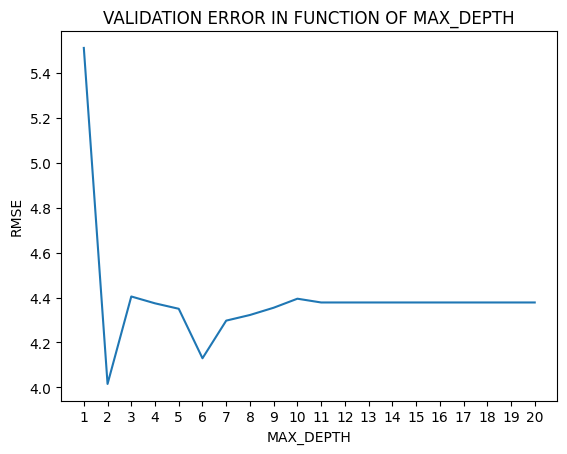

In [33]:
plt.title("VALIDATION ERROR IN FUNCTION OF MAX_DEPTH")

plt.plot(range(1, MAX_DEPTH_TRIES+1), list(map(lambda r: r[1], results)))

plt.xticks(range(1, MAX_DEPTH_TRIES+1))

plt.xlabel("MAX_DEPTH")
plt.ylabel("RMSE")

plt.show()

In [38]:
best_tree = min(results, key=lambda r: r[1])[2]

y_test = predict(best_tree, X_test)

y_test = y_test.to_numpy().reshape(-1, 1)

root_mean_squared_error(y_test, t_test)

np.float64(6.800821671010227)